# Athena Rationales Empirical Visualization
Large Scale Empirical Analysis 

In [1]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools

pd.options.display.float_format = '{:.2f}'.format

In [2]:
from tokenizers import ByteLevelBPETokenizer
import torch
import importlib
from fairseq.models.transformer import TransformerModel

In [3]:
import warnings
from matplotlib import colors
import os
from rationalization import rationalize_lm, rationalize_conditional_model

In [4]:
def param_default():
    corpus = 'fm_fc_ms_ff' #<-- Scope
    data_path = Path('../athena-datasets/' + corpus + '/')
    data_path_raw = Path('../athena-datasets/' + corpus + '/raw/')
    tokenizer_path = Path('../tokenizer/')
    return {
        'bpe_path' : tokenizer_path / 'universal_tokenizer/universal_tokenizer/roberta_aug_spaces',
        'eval_raw': [data_path_raw / 'eval/input.methods.txt',
                        data_path_raw / 'eval/output.tests.txt'],
        'test_raw': [data_path_raw / 'test/input.methods.txt', 
                        data_path_raw / 'test/output.tests.txt'],
        'train_raw': [data_path_raw / 'train/input.methods.txt', 
                        data_path_raw / 'train/output.tests.txt'],
        'data_labels' : ['eval_raw','test_raw','train_raw'],
        'output_pandas' : data_path / 'pandas/',
        'out_processed' : '/datasets/out_processed/',
        'model_name_or_path' : 'models/checkpoint_dir_01/models/', #Model Path
        'checkpoint_file': 'checkpoint_best.pt', #Model
        'data_preprocessed':'/home/davidna/data/dummy/sequential-rationales/fairseq/fairseq/data-bin/bins/',
        'output_results' : 'results/' 
    }

In [5]:
params = param_default()
params['output_results']

'results/'

In [6]:
params['eval_raw']

[PosixPath('../athena-datasets/fm_fc_ms_ff/raw/eval/input.methods.txt'),
 PosixPath('../athena-datasets/fm_fc_ms_ff/raw/eval/output.tests.txt')]

In [7]:
sns.set_theme(style="darkgrid")

## Universal Tokenizer

In [8]:
def load_tokenizer(bpe_path):
    return ByteLevelBPETokenizer(str(bpe_path)+'-vocab.json',str(bpe_path)+'-merges.txt')

In [9]:
def lazy_decode(bpe_java):
    return bpe_java.replace(' ','').replace('Ġ',' ').replace('Ċ','\n')

In [10]:
def prettify_java(minified_java):
    "tries to undo Michele's minification. Works decently, although for loops and sets get newlines inserted, and there are no empty lines or comments"
    minified_java = minified_java.replace('{','{\n').replace('}','}\n').replace(';',';\n')
    num_indents = 0
    pretty_java = ''
    for line in minified_java.splitlines():
        if line.lstrip().startswith('}'):
            num_indents -= 1
        pretty_java += num_indents*'    '+line+'\n'
        if line.endswith('{'):
            num_indents += 1
        if line.endswith('}') and not line.lstrip().startswith('}'):
            num_indents -= 1
    return pretty_java

In [11]:
tokenizer = load_tokenizer(params['bpe_path'])

# Loading Rationales From Trials

In [12]:
#Loading one trial
df_rationale_output = pd.read_json( params['output_results'] + 'rationales_1_gen_02/' + 'rationales_[t_1000]_[max_src_100]_[max_tgt_100]_02_[exp:0]_.json' ) 

In [13]:
df_rationale_output.head(2) ##All Rationales for each sample

,goal_token,from_seq_id,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src
0,Test,0,"[[@, 0.9980469942]]",[],[0],[],[0.9980469942],[]
1,Ġpublic,0,"[[Test, 0.9563337564000001]]",[],[1],[],[0.9563337564000001],[]


In [14]:
df_rationale_output.shape

(63682, 8)

## Rationales by General Taxonomy

In [15]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<;>": ";",
    "<return>": "return"
  },
  "exceptions": {
    "<catch>": "catch",
    "<try>": "try",
    "<finally>": "finally",
    "<throw>": "throw",
    "<throws>": "throws"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<private>": "private",
    "<protected>": "protected",
    "<public>": "public",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<package>": "package",
    "<this>": "this",
    "<implements>": "implements",
    "<import>": "import",
    "<new>": "new",
    "<super>": "super"
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<native>": "native",
    "<static>": "static",
    "<synchronized>": "synchronized",
    "<transient>": "transient",
    "<volatile>": "volatile",
    "<void>": "void",
    "<final>": "final",
    "<enum>": "enum"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "datatypes": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [16]:
tkn_taxonomy = token_taxonomy()

In [17]:
def print_heatmap(
        np_rationales, 
        fig_size = (10,10), 
        font = 15,
        yticklabels = list( tkn_taxonomy.keys() ), 
        xticklabels = list( tkn_taxonomy.keys() )
):
        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(np_rationales, cmap="YlGnBu", 
                yticklabels=yticklabels, 
                xticklabels=xticklabels,
                ax=ax)
        plt.show
        pass

In [18]:
#Map-Reduce Aggregation by Taxonomy
def map_rationale_by_tax(arr_typeset, tkn_taxonomy, non_stringent = True):
    list_category_prob = []
    list_category_token = []
    for typeset_row in arr_typeset: #Iterating rationales
        #print(typeset_row)
        dict_category_prob = {}
        dict_category_token = {}
        for category in tkn_taxonomy.keys(): #Iterating on Tax-Categories
            set_elems = set( tkn_taxonomy[category].values() )
            if non_stringent:
                set_elems = set_elems.union( set(['Ġ'+tok_elem for tok_elem in set_elems]) )
            dict_category_prob[category] = [ token_tuple[1] for token_tuple in typeset_row if token_tuple[0] in set_elems ]
            dict_category_token[category] = [ token_tuple for token_tuple in typeset_row if token_tuple[0] in set_elems ]
        list_category_prob.append( dict_category_prob ) 
        list_category_token.append( dict_category_token )  
    return list_category_prob, list_category_token

In [19]:
p_rationale = df_rationale_output

In [20]:
list_category_prob_tgt, list_category_token_tgt = map_rationale_by_tax( arr_typeset=p_rationale.typesets_tgt.values, 
                                                tkn_taxonomy=tkn_taxonomy )
list_category_prob_src, list_category_token_src = map_rationale_by_tax( arr_typeset=p_rationale.typesets_src.values, 
                                                tkn_taxonomy=tkn_taxonomy )

In [21]:
p_rationale['category_prob_tgt'] = list_category_prob_tgt
p_rationale['category_token_tgt'] = list_category_token_tgt

p_rationale['category_prob_src'] = list_category_prob_src
p_rationale['category_token_src'] = list_category_token_src

In [22]:
p_rationale.head(1)

,goal_token,from_seq_id,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src,category_prob_tgt,category_token_tgt,category_prob_src,category_token_src
0,Test,0,"[[@, 0.9980469942]]",[],[0],[],[0.9980469942],[],"{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't..."


In [23]:
dict_reduce_tax_prob_tgt = {k:[] for k in tkn_taxonomy.keys() } #dict.fromkeys( tkn_taxonomy.keys(), [] )
dict_reduce_tax_prob_src = {k:[] for k in tkn_taxonomy.keys() } #dict.fromkeys( tkn_taxonomy.keys(), [] )

In [24]:
non_stringent = True
for token_elem in set(p_rationale.goal_token.values):
    for category in tkn_taxonomy.keys(): #Iterating on Tax-Categories
        set_elems = set( tkn_taxonomy[category].values() )
        if non_stringent:
            set_elems = set_elems.union( set(['Ġ'+tok_elem for tok_elem in set_elems]) )
        if token_elem in set_elems:
            dict_reduce_tax_prob_tgt[category] = p_rationale[ p_rationale['goal_token'] == token_elem ].category_prob_tgt.values
            dict_reduce_tax_prob_src[category] = p_rationale[ p_rationale['goal_token'] == token_elem ].category_prob_src.values 

In [25]:
def merge_tax_dict(dict_a, dict_b):
    return {elem: dict_a[elem] + dict_b[elem]  for elem in dict_a}

In [26]:
def reduce_tax_dict( dict_reduce_tax_prob ):
    for tax in dict_reduce_tax_prob:
        if len(dict_reduce_tax_prob[tax]) > 0:
            dict_reduce_tax_prob[tax] = functools.reduce(lambda a, b: merge_tax_dict(a,b), dict_reduce_tax_prob[tax])
    pass

In [27]:
def reduce_tax_dict( dict_reduce_tax_prob ):
    return {lis: functools.reduce(lambda a, b: merge_tax_dict(a,b), dict_reduce_tax_prob[lis]) if len(dict_reduce_tax_prob[lis])>0 else {}  for lis in dict_reduce_tax_prob }

In [28]:
dict_reduce_tax_prob_tgt = reduce_tax_dict( dict_reduce_tax_prob= dict_reduce_tax_prob_tgt)
dict_reduce_tax_prob_src = reduce_tax_dict( dict_reduce_tax_prob= dict_reduce_tax_prob_src)

In [32]:
def reducing_rationales( 
    dict_reduce_tax_prob,  
    rows = len( tkn_taxonomy.keys() ), 
    columns = len( tkn_taxonomy.keys() ), 
    agg_f = np.mean ):
    #Independent Variable: Source Rows
    #Dependent Variable: Target Columns
    np_rationales = np.zeros( ( rows, columns ) )
    for i, row_tax in enumerate( dict_reduce_tax_prob ):
        dict_inner = dict_reduce_tax_prob[row_tax]
        #print(i)
        if dict_inner:
            #print(i)
            for j, column_tax in enumerate( dict_inner ):
                #print(j)
                list_tax = dict_inner[column_tax]
                if list_tax:
                    np_rationales[i][j] = agg_f( list_tax ) #Agregation Function
    return np_rationales

## From Target to Target

In [33]:
np_rationales_avg = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_tgt, agg_f = np.mean)
np_rationales_min = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_tgt, agg_f = np.min)

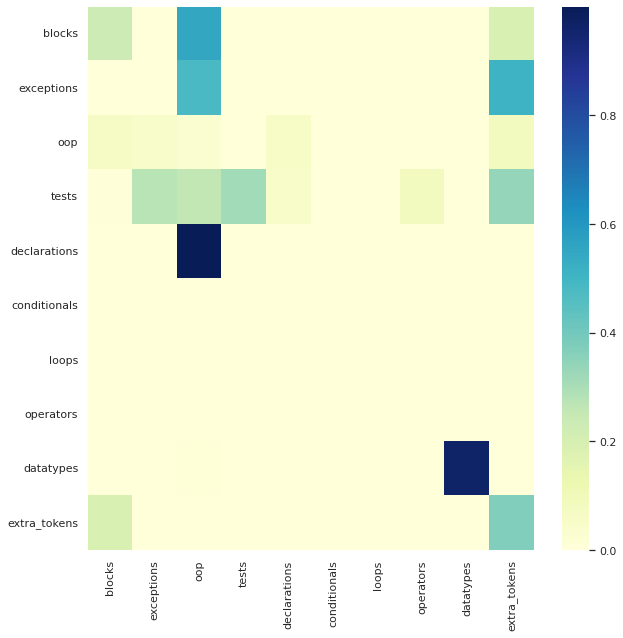

In [38]:
print_heatmap(
    np_rationales=np_rationales_avg, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

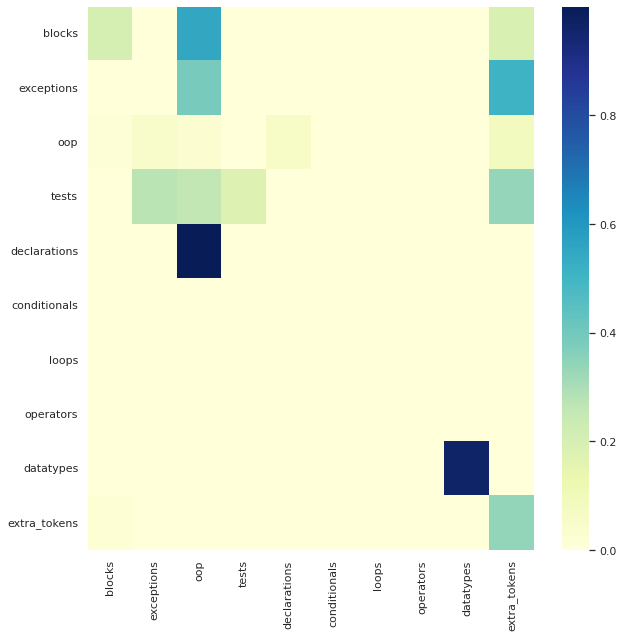

In [39]:
print_heatmap(
    np_rationales=np_rationales_min, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

## From Source to Target

In [40]:
np_rationales_avg = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_src, agg_f = np.mean)
np_rationales_min = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_src, agg_f = np.min)

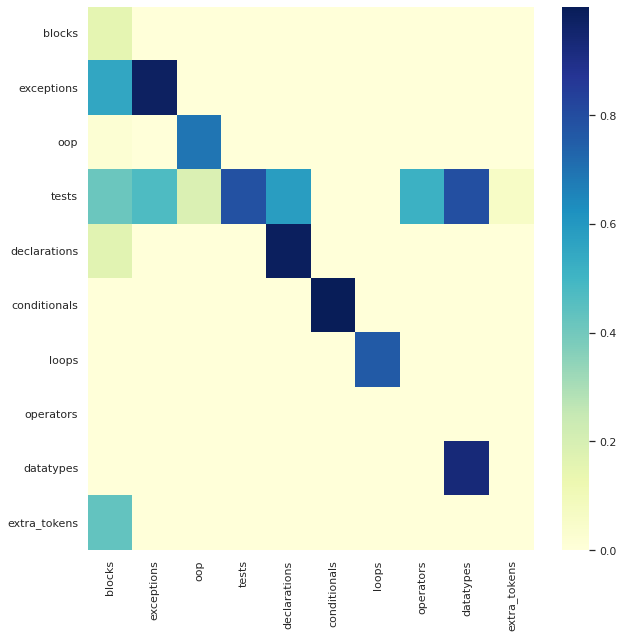

In [41]:
print_heatmap(
    np_rationales=np_rationales_avg, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

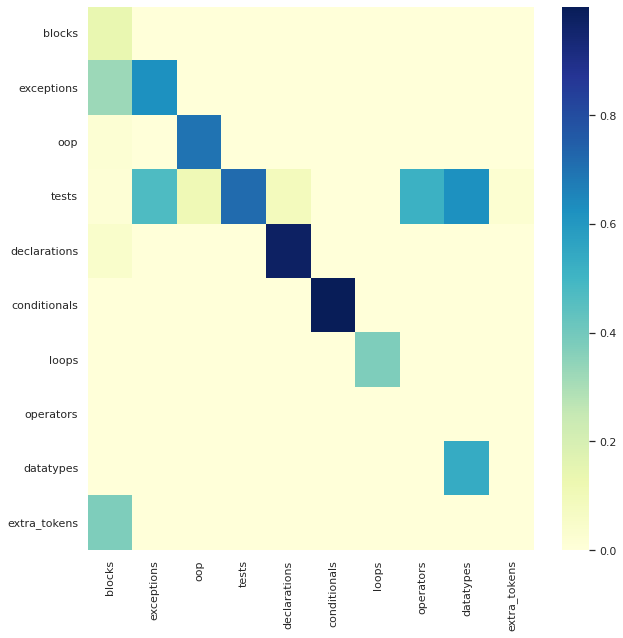

Bad pipe message: %s [b'i\xde3\x12\x90=\xa7\xf4\x01\x97\x1e\x96\x81\xbfDE\xf3\xe7 \x01\xf8 l\xaf\xee\x0e\x9e\xcc']
Bad pipe message: %s [b'\xa8-\xbe\xc2b\xd4\x9aq\xb8\x9c{\xe4\xed\x98\xc8[\x1cw\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc']
Bad pipe message: %s [b"\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17"]
Bad pipe message: %s [b"\xed/\xd1K\xe9\x80\x18\xac.\x04xO\x18\xb6Z\xa7\xda\x8d\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\

In [43]:
print_heatmap(
    np_rationales=np_rationales_min, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )